In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import vice
import apogee_analysis as aah
from astropy.table import Table
import plotting
import fitsio
import astropy as ap
import astropy.units as u

In [3]:
file_name = "allStar-dr17-synspec_rev1.fits.1"

In [4]:
ff = fits.open(file_name)
da = ff[1].data
ff.close()

In [ ]:
# cuts in W+19
mask = da["LOGG"] > 1
mask &= da["LOGG"] < 2
mask &= da["SNR"] > 80
filtered = da[mask]
del da

In [ ]:
plt.scatter(filtered["GLON"], filtered["GAIAEDR3_R_MED_GEO"])

In [ ]:
# Calculate galactocentric coordinates
import astropy.coordinates as coord
c = coord.SkyCoord(ra = filtered["RA"] * u.degree,
                           dec = filtered["DEC"] * u.degree,
                           distance = filtered["GAIAEDR3_R_MED_GEO"] * u.pc,
                           frame="icrs")
gc_c = c.transform_to(coord.Galactocentric)
R_gal = np.array(np.sqrt(gc_c.x**2 + gc_c.y**2) / 1e3)
abs_z = np.array(np.abs(gc_c.z) / 1e3)


In [ ]:
plt.scatter(R_gal, abs_z, c=filtered["GLON"], s=0.1, alpha=0.1)
plt.colorbar(label="Galactic Longitude")
plt.xlabel("R_gal (kpc)")
plt.ylabel("z (kpc)")
plt.xlim(0, 20)
plt.ylim(0, 20)

In [ ]:
plt.scatter(filtered["GLON"], filtered["GLAT"], c=R_gal, s=0.1, alpha=0.1, vmax=20)
plt.colorbar(label="R_gal (kpc)")

In [ ]:
o_h = filtered["O_Fe"] + filtered["Fe_H"]
c_o = filtered["C_Fe"] - filtered["O_Fe"]
c_n = - filtered["N_Fe"] - filtered["C_Fe"]
fe_h = filtered["Fe_H"]
m_h = filtered["M_H"]
logg = filtered["LOGG"]

In [ ]:
plt.scatter(filtered["Fe_H"], filtered["O_Fe"], c=abs_z, s=0.1, alpha=0.5, vmax=20)
plt.ylim(-1,1)
plt.xlim(-3,2)
plt.ylabel("[O/Fe]")
plt.xlabel("[Fe/H]")
plt.colorbar()

In [ ]:
plt.scatter(fe_h, c_n, s=0.01, c=logg, vmin=0)
plt.xlim(-2, 1)
plt.ylim(-2, 2)
plt.xlabel("[fe/h]")
plt.ylabel("[c/n]")
plt.colorbar()

In [ ]:
xlim = (-1, 0.6)
for ele in ["C", "N", "O"]:
    plotting.density_scatter(fe_h, filtered["%s_FE" % ele], xlim=xlim, ylim=(-0.5, 0.5))
    plt.xlabel("[Fe/H]")
    plt.ylabel("[%s/Fe]" % ele)
    plt.show()

In [ ]:
plotting.density_scatter(fe_h, filtered["O_FE"], xlim=(-1,0.7), ylim=(0, 0.4))
plt.xlabel("fe/h")
plt.ylabel('o/fe')
x = np.linspace(-1, 0.7)
y = o_fe_fe_h_cutoff(x)

plt.plot(x, y)

In [ ]:
def o_fe_fe_h_cutoff(fe_h):
    return 0.21 - 0.15*(fe_h + 0.3) *(fe_h < -0.3)

In [ ]:
low_fe = filtered["O_FE"]  > o_fe_fe_h_cutoff(filtered["FE_H"])

In [ ]:
plt.scatter(o_h, filtered["C_FE"] - filtered["O_FE"], c=low_fe, alpha=0.1, s=0.1)
plt.xlabel("o/h")
plt.ylabel("c/o")

In [ ]:
plt.subplot?

In [ ]:
def plot_in_gal_region(x, y, xlabel=None, ylabel=None):
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True)
    for j in range(5);
        R_min, R_max = [(1, 3), (3, 5), (5,7), (7,9), (9,11), (11,13)][j]
    
        plt.figure(figsize=(20, 5))
        for i in range(3):
            z_min, z_max = [(0, 0.5), (0.5, 1), (1, 2)][i]
            
            mask = R_gal > R_min
            mask &= R_gal < R_max
            mask &= abs_z > z_min
            mask &= abs_z < z_max
            
            plt.subplot(5, 3, j, i + 1, sharex=True, sharey = True)
            plotting.density_scatter(x[mask], y[mask])
            
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.title("R = %s - %s, z = %s - %s" %(R_min, R_max, z_min, z_max))
        plt.show()

In [ ]:
plot_in_gal_region(filtered["FE_H"], filtered["O_FE"])

In [ ]:
plot_in_gal_region(o_h, c_o, xlabel="[O/H]", ylabel="[C/O]")

In [ ]:
plot_in_gal_region(fe_h, c_n, xlabel="[O/H]", ylabel="[C/N]")

In [ ]:
plt.scatter(T, logg)

In [ ]:
plotting.density_scatter(T, logg)

In [ ]:
v21 = aah.vincenzo2021()

In [ ]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=0.1, alpha=0.2, label="V21")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
plt.scatter(o_h, c_o, s=0.1, alpha=0.1, label="APOGEE")
plt.xlim(-1,0.7)
plt.ylim(-0.7, 0.6)
plt.legend(markerscale=10)

In [ ]:
f = open("CNOdredgeup.obj", "rb")
raw = pickle.load(f, encoding = "bytes")
f.close()

In [ ]:
raw

In [ ]:
plt.hist(filtered["VSINI"][filtered["VSINI"] > 0])

In [ ]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=1)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

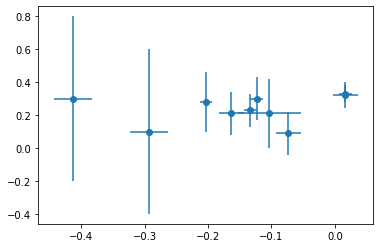

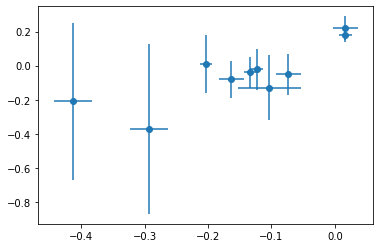

In [49]:
# rom skillman 2020, table 2
# https://ui.adsabs.harvard.edu/abs/2020ApJ...894..138S/abstract

aah.plot_skillman20_cnoh()
plt.show()
aah.plot_skillman20_cooh()

Text(0, 0.5, '[c/o]')

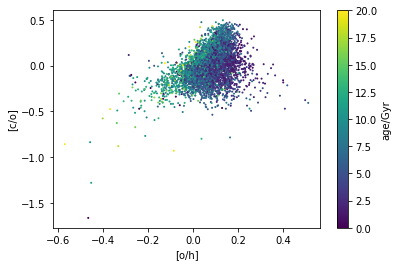

In [165]:
plt.scatter(v21["[c/o]"] , v21["[o/h]"], c=v21["age"], vmin=0, s=1)
plt.colorbar(label="age/Gyr")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

# MultiProcess Model

Trying to apply methods from W+19 to AGB star yields. 